We can find the minimal outer ellipsoid of a basic semi-algebraic set $\{x | p_i(x) \le 0, i=1, ..., N\}$ through a convex optimization. In this notebook, we demonstrate our approach on a 3D example.

In [38]:
import jupyter_black

jupyter_black.load()
import numpy as np
import matplotlib.pyplot as plt
import pydrake.solvers as solvers
import pydrake.symbolic as sym
import minimal_outer_ellipsoid.ellipsoid as ellipsoid

Our inner basic semi-algebraic set is $\{x | x_0^4 + x_1^4 + x_2 - 1.925x_0^2x_1^2 - 1 \le 0, x_2 \ge 0\}$, we first draw this set below

/tmp/ipykernel_33862/3755206518.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


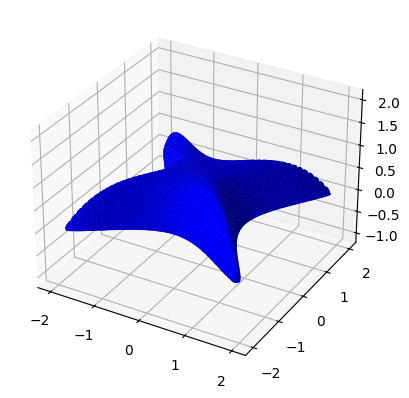

In [39]:
def plot_inner_shape(ax):
    X, Y = np.meshgrid(np.linspace(-2, 2, 2000), np.linspace(-2, 2, 2000))
    Z = 1 - X**4 - Y**4 + 1.925 * X**2 * Y**2
    Z1 = np.copy(Z)
    Z1[Z1 < 0] = np.nan
    ax.plot_surface(X, Y, Z1, color="b")
    Z2 = np.zeros_like(X)
    Z2[Z < 0] = np.nan
    ax.plot_surface(X, Y, Z2, color="b")


fig = plt.figure()
ax = fig.add_subplot(projection="3d")
plot_inner_shape(ax)
ax.axis("equal")
fig.show()

In [40]:
prog = solvers.MathematicalProgram()
x = prog.NewIndeterminates(3, "x")
S = prog.NewSymmetricContinuousVariables(3, "S")
b = prog.NewContinuousVariables(3, "b")
c = prog.NewContinuousVariables(1, "c")[0]

inner_polynomials = np.array(
    [
        sym.Polynomial(
            x[0] ** 4 + x[1] ** 4 + x[2] - 1.925 * x[0] ** 2 * x[1] ** 2 - 1
        ),
        sym.Polynomial(-x[2]),
    ]
)
ellipsoid.add_containment_constraint(
    prog,
    x,
    inner_polynomials,
    S,
    b,
    c,
    inner_poly_lagrangians_degrees=[2, 4],
    ellipsoid_lagrangian=None,
)  # sym.Polynomial(x[0]**2 + x[1]**2 + x[2]**2))

ellipsoid.add_minimize_volume_cost(prog, S, b, c)

result = solvers.Solve(prog)
assert result.is_success()
S_sol = result.GetSolution(S)
b_sol = result.GetSolution(b)
c_sol = result.GetSolution(c)

/tmp/ipykernel_33862/2084691786.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_33862/2084691786.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


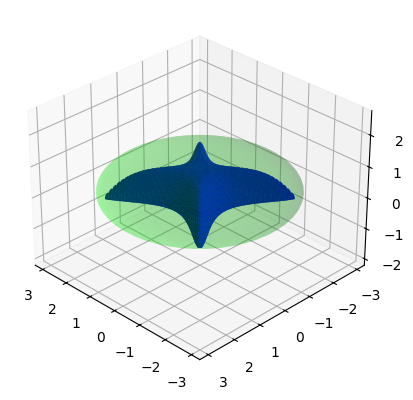

In [44]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
plot_inner_shape(ax)

# Now plot the ellipsoid.
A, d = ellipsoid.to_affine_ball(S_sol, b_sol, c_sol)

U, V = np.meshgrid(np.linspace(0, 2 * np.pi, 50), np.linspace(0, np.pi, 50))
X_sphere = np.cos(U) * np.sin(V)
Y_sphere = np.sin(U) * np.sin(V)
Z_sphere = np.cos(V)
XYZ_ellipsoid = A @ (
    np.concatenate(
        (
            X_sphere.reshape((1, -1)),
            Y_sphere.reshape((1, -1)),
            Z_sphere.reshape((1, -1)),
        ),
        axis=0,
    )
    + d.reshape((-1, 1))
)
X_ellipsoid = XYZ_ellipsoid[0, :].reshape(X_sphere.shape)
Y_ellipsoid = XYZ_ellipsoid[1, :].reshape(X_sphere.shape)
Z_ellipsoid = XYZ_ellipsoid[2, :].reshape(X_sphere.shape)
for i, azim in enumerate(np.linspace(-45, 45, 20)):
    ax.view_init(azim=azim)
    fig.show()
    fig.savefig(f"3d_without_ellipsoid{i}.png", format="png")
ax.plot_surface(X_ellipsoid, Y_ellipsoid, Z_ellipsoid, color=[0, 1, 0, 0.2])
ax.axis("equal")
for i, azim in enumerate(np.linspace(45, 135, 20)):
    ax.view_init(azim=azim)
    fig.show()
    fig.savefig(f"3d_with_ellipsoid{i}.png", format="png")
fig.show()